<a href="https://colab.research.google.com/github/princessivy/Analyzing_CSGO_SkinPrices/blob/main/CSGO_Significance_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
from pathlib import Path

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Daten einlesen

In [3]:
data = pd.read_csv(r'/content/drive/MyDrive/SA_BA/Data/allitems_cleaned_3.csv')

# Anpassung der Daten für die Tests

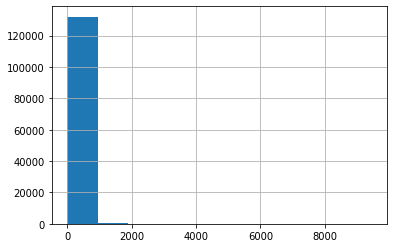

In [ ]:
# Darstellung Preis
data.salePrice.hist()

In [8]:
data['salePricelog'] = np.log(data['salePrice'])

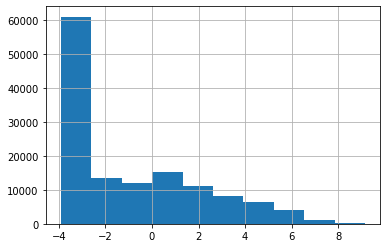

In [ ]:
# Darstellung logarithmierter Preis
data.salePricelog.hist()

Bisher wurden nur die Ausreißer nach oben entfernt. Allerdings gibt es sehr viele Skins, die sehr billig sind, was durch die vorherige EDA sehr deutlich wird und die folgenden Quantile ebenso beweisen. Auch der logarithmierte Preis zeigt eine unschöne Verteilung.

In [ ]:
data.salePrice.quantile(0.5)

0.12

Heißt, 50% der Skins kosten weniger als 12 Cent. 

In [ ]:
data.salePrice.quantile(0.75)

3.0

Heißt, 75% der Skins kosten weniger als 3 Euro.

In [ ]:
# Mittelwert des Preises
print("Mittelwert von salePrice (in EUR): " + str(round(data.salePrice.mean(),2)))

# Median des Preises
print("Median von salePrice (in EUR): " + str(round(data.salePrice.median(),2)))

Mittelwert von salePrice (in EUR): 31.34
Median von salePrice (in EUR): 0.12


Es ist nicht Sinn dieser Arbeit, der Signifikanz und dem Modell die Daten im unteren Preisbereich zu übergeben. Auf diesen Beobachtungen ist es uninteressant, Wissen über die Daten aufzubauen und würde das Ergebnis nur verzerren. Entsprechend wird sich ab jetzt auf die Skins konzentriert, die mindestens 5 Euro kosten.

In [4]:
data = data[data.salePrice >= 5]

In [ ]:
# Mittelwert des Preises
print("Mittelwert von salePrice (in EUR): " + str(round(data.salePrice.mean(),2)))

# Median des Preises
print("Median von salePrice (in EUR): " + str(round(data.salePrice.median(),2)))

Mittelwert von salePrice (in EUR): 149.47
Median von salePrice (in EUR): 34.5


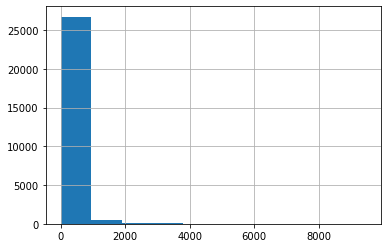

In [ ]:
# Darstellung Preis mit Skins >= 5 EUR
data.salePrice.hist()

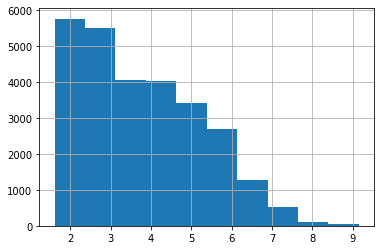

In [ ]:
# Darstellung logarithmierter Preis mit Skins >= 5 EUR
data.salePricelog.hist()

Beim logarithmierten salePrice mit Skinpreis-Werten mit mindestens 5 ist eine deutlich angenehmere Verteilung zu erkennen. Entsprechend wird mit diesen Daten weiter verfahren.

In [ ]:
print("Von 132789 Beobachtungen sind durch die Kürzung der Daten bezüglich des Preises >= 5 Euro noch " + str(len(data)) + " Beobachtungen übrig.")

Von 132789 Beobachtungen sind durch die Kürzung der Daten bezüglich des Preises >= 5 Euro noch 27460 Beobachtungen übrig.


# Datenaufbereitung für Signifikanztest (und für Modell später)

In [ ]:
# übrige Features:
data.columns

Index(['index', 'assetId', 'family', 'lock', 'version', 'suggestedPrice',
       'salePrice', 'category', 'subCategory', 'pattern', 'wear', 'exterior',
       'quality', 'rarity', 'collection', 'stickers', 'souvenir', 'stattrak',
       'colorfulness', 'cats_colorfulness', 'salePricelog'],
      dtype='object')

Die Features *index* und *assetId* können direkt gelöscht werden, da diese nur zur Unterstützung der Visualisierungen dienten.

In [6]:
data = data.drop(['index', 'assetId'], axis = 1)

In [ ]:
# kategorische Features filtern
data.dtypes

family                object
lock                   int64
version               object
suggestedPrice       float64
salePrice            float64
category              object
subCategory           object
pattern                int64
wear                 float64
exterior              object
quality               object
rarity                object
collection            object
stickers               int64
souvenir               int64
stattrak               int64
colorfulness         float64
cats_colorfulness     object
salePricelog         float64
dtype: object

Kategorisch:
* family
* version
* category
* subCategory
* exterior
* quality
* rarity
* collection
* cats_colorfulness

**Einordnung Skalenniveaus:**

Davon ordinalskaliert mit Anzahl Ausprägungen:
* exterior, 5
* rarity, 7
* cats_colorfulness, 6

Davon nominalskaliert mit Anzahl Ausprägungen:
* family, 818
* version, 20
* category, 6
* subCategory, 61
* quality, 5
* collection, 75

## Ordinale Daten: Label-Encoding oder One-Hot-Encoding?

### Version 1: Label-Encoding

**Im Folgenden werden die ordinalskalierten Daten encodiert (Label-Encoding):**  
*(mir ist bewusst, dass es hierfür auch from sklearn.preprocessing import LabelEncoder gibt, allerdings kann ich durch manuelles Arbeiten sicher gehen, dass die Zahlen in der richtigen Reihenfolge vergeben werden)*

In [ ]:
data_lab = data.copy()

**exterior**  
Reihenfolge von gut zu schlecht: Factory New, Minimal Wear, Field-Tested, Well-Worn, Battle-Scarred.  
Entsprechend enthält Battle-Scarred den niedrigsten und Factory New den höchsten Wert.

In [ ]:
data_lab.exterior.unique()

array(['Factory New', 'Minimal Wear', 'Field-Tested', 'Battle-Scarred',
       'Well-Worn'], dtype=object)

In [ ]:
def encode_exterior(x):
  if x == 'Factory New':
    return 5
  elif x == 'Minimal Wear':
    return 4
  elif x == 'Field-Tested':
    return 3
  elif x == 'Well-Worn':
    return 2
  elif x == 'Battle-Scarred':
    return 1

In [ ]:
data_lab.exterior = data_lab.exterior.apply(encode_exterior)

**rarity**  
Reihenfolge von gut zu schlecht: Extraordinary, Covert, Classified, Restricted, Mil-Spec Grade, Industrial Grade, Consumer Grade.  

In [ ]:
data_lab.rarity.unique()

array(['Covert', 'Restricted', 'Mil-Spec Grade', 'Classified',
       'Industrial Grade', 'Consumer Grade', 'Extraordinary'],
      dtype=object)

Bemerkung: In *Extraordinary* stecken alle Skins der Kategorie Gloves. Diese sind mit *Covert* gleichgestellt. Entsprechend werden diese in die gleichie Kategorie fallen.

In [ ]:
data_lab[data_lab['rarity'] == 'Extraordinary'].category.unique()

array(['Gloves'], dtype=object)

In [ ]:
def encode_rarity(x):
  if (x == 'Extraordinary') or (x == 'Covert'):
    return 6
  elif x == 'Classified':
    return 5
  elif x == 'Restricted':
    return 4
  elif x == 'Mil-Spec Grade':
    return 3
  elif x == 'Industrial Grade':
    return 2
  elif x == 'Consumer Grade':
    return 1

In [ ]:
data_lab.rarity = data_lab.rarity.apply(encode_rarity)

**cats_colorfulness**

Reihenfolge von gut zu schlecht: extremely colorful, highly colorful, quite colorful, averagely colorful, moderately colorful, slightly colorful, not colorful.

In [ ]:
data_lab.cats_colorfulness.unique()

array(['highly colorful', 'quite colorful', 'slightly colorful',
       'moderately colorful', 'averagely colorful', 'extemely colorful'],
      dtype=object)

In [ ]:
def encode_colors(x):
  if x == 'extemely colorful':
    return 6
  elif x == 'highly colorful':
    return 5
  elif x == 'quite colorful':
    return 4
  elif x == 'averagely colorful':
    return 3
  elif x == 'moderately colorful':
    return 2
  elif x == 'slightly colorful':
    return 1
  elif x == 'not colorful': #gibt's nicht
    return 0

In [ ]:
data_lab.cats_colorfulness = data_lab.cats_colorfulness.apply(encode_colors)

#### Signifikanztest

In [ ]:
y = data_lab['salePricelog']
X = data_lab[['exterior', 'rarity', 'cats_colorfulness']]

In [ ]:
model_lr = LinearRegression()

In [ ]:
X = sm.add_constant(X)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
model = sm.OLS(y,X)
results = model.fit()

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           salePricelog   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     2757.
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        09:25:26   Log-Likelihood:                -46328.
No. Observations:               27460   AIC:                         9.266e+04
Df Residuals:                   27456   BIC:                         9.270e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2147      0.04

23,10% der Varianz wird durch die Daten erklärt und alle Features sind signifikant.

### Version 2: One-Hot-Encoding

Nun wird geguckt, ob sich mittels One-Hot-Encoding eine höhere erklärbare Varianz ergibt.

In [ ]:
# exterior
data2 = pd.get_dummies(data.exterior, prefix='ext')
data2 = pd.concat([data, data2], axis=1)

In [ ]:
# rarity
data3 = pd.get_dummies(data.rarity, prefix='rar')
data2 = pd.concat([data2, data3], axis=1)

In [ ]:
# cats_colorfulness
data3 = pd.get_dummies(data.cats_colorfulness, prefix='color')
data2 = pd.concat([data2, data3], axis=1)

#### Signifikanztest

In [ ]:
y = data['salePricelog']
X = data2[['ext_Battle-Scarred', 'ext_Factory New', 'ext_Field-Tested',
       'ext_Minimal Wear', 'ext_Well-Worn', 'rar_Classified',
       'rar_Consumer Grade', 'rar_Covert', 'rar_Extraordinary',
       'rar_Industrial Grade', 'rar_Mil-Spec Grade', 'rar_Restricted',
       'color_averagely colorful', 'color_extemely colorful',
       'color_highly colorful', 'color_moderately colorful',
       'color_quite colorful', 'color_slightly colorful']]

In [ ]:
model_lr = LinearRegression()

In [ ]:
X = sm.add_constant(X)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
model = sm.OLS(y,X)
results = model.fit()

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           salePricelog   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     897.3
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        09:20:26   Log-Likelihood:                -44464.
No. Observations:               27460   AIC:                         8.896e+04
Df Residuals:                   27444   BIC:                         8.909e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Die Varianz der Daten lässt sich mittels One-Hot-Encoding der ordinalskalierten Daten zu 32,90% erklären. Nur das Feature 'color_extremely colorful' ist nicht signifikant. 

Somit werden die ordinalskalierten Daten im weiteren Verlauf mittels One-Hot-Encoding behandelt.

## Nominalskalierte Daten

* family, 818
* version, 20
* category, 6
* subCategory, 61
* quality, 5
* collection, 75

**family**

In [ ]:
data2 = pd.get_dummies(data.family, prefix='fam')

In [ ]:
cols = data2.columns

In [ ]:
data2 = pd.concat([data, data2], axis=1)

In [ ]:
y = data['salePricelog']
X = data2[cols]

In [ ]:
model_lr = LinearRegression()

In [ ]:
X = sm.add_constant(X)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
model = sm.OLS(y,X)
results = model.fit()

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           salePricelog   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     64.70
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        09:46:31   Log-Likelihood:                -34932.
No. Observations:               27460   AIC:                         7.150e+04
Df Residuals:                   26642   BIC:                         7.822e+04
Df Model:                         817                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [ ]:
# Liste erstellen mit signifikanten Features
p_family = pd.DataFrame({'family_characters':results.pvalues.index, 'p-value':results.pvalues.values})

In [ ]:
p_family_sig = p_family[~(p_family['p-value'] > 0.05)]

In [ ]:
p_family_sig = p_family_sig.reset_index()

In [ ]:
p_family_sig

,index,family_characters,p-value
0,0,const,0.000000e+00
1,1,fam_3rd Commando Company,8.067527e-16
2,2,fam_Abyss,1.423783e-04
3,3,fam_Abyssal Apparition,8.483180e-04
4,4,fam_Acheron,6.510742e-05
...,...,...,...
500,813,fam_Yellow-banded,3.345097e-21
501,814,fam_ZX Spectron,6.540603e-09
502,815,fam_Ziggy,2.089990e-02
503,816,fam_Zirka,7.986285e-06


**version**

In [ ]:
data2 = pd.get_dummies(data.version, prefix='vers')

In [ ]:
cols = data2.columns

In [ ]:
data2 = pd.concat([data, data2], axis=1)

In [ ]:
y = data['salePricelog']
X = data2[cols]

In [ ]:
model_lr = LinearRegression()

In [ ]:
X = sm.add_constant(X)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
model = sm.OLS(y,X)
results = model.fit()

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           salePricelog   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     99.26
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        13:50:48   Log-Likelihood:                -49031.
No. Observations:               27460   AIC:                         9.810e+04
Df Residuals:                   27440   BIC:                         9.827e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.3076      0.161  

In [ ]:
# Liste mit signifikanten Features
p_version = pd.DataFrame({'version_characters':results.pvalues.index, 'p-value':results.pvalues.values})

In [ ]:
p_version_sig = p_version[~(p_version['p-value'] > 0.05)]

In [ ]:
p_version_sig = p_version_sig.reset_index()

In [ ]:
p_version_sig

,index,version_characters,p-value
0,0,const,6.665340e-235
1,7,vers_Black Pearl,3.934689e-06
2,9,vers_FFI,4.575889e-03
3,11,vers_Phase 1,1.062900e-05
4,12,vers_Phase 2,1.732095e-06
5,13,vers_Phase 3,2.357031e-05
6,14,vers_Phase 4,1.265914e-04
7,16,vers_Ruby,8.484077e-15
8,17,vers_Sapphire,1.138888e-14
9,19,vers_Tier 2,4.655640e-03


**category**

In [ ]:
data2 = pd.get_dummies(data.category, prefix='cat')

In [ ]:
cols = data2.columns

In [ ]:
data2 = pd.concat([data, data2], axis=1)

In [ ]:
y = data['salePricelog']
X = data2[cols]

In [ ]:
model_lr = LinearRegression()

In [ ]:
X = sm.add_constant(X)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
model = sm.OLS(y,X)
results = model.fit()

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           salePricelog   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     3047.
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        14:03:39   Log-Likelihood:                -42936.
No. Observations:               27460   AIC:                         8.589e+04
Df Residuals:                   27453   BIC:                         8.594e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.402e+11   1.14e+12     -0.476      0.6

**subCategory**

In [ ]:
data2 = pd.get_dummies(data.subCategory, prefix='subCat')

In [ ]:
cols = data2.columns

In [ ]:
data2 = pd.concat([data, data2], axis=1)

In [ ]:
y = data['salePricelog']
X = data2[cols]

In [ ]:
model_lr = LinearRegression()

In [ ]:
X = sm.add_constant(X)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
model = sm.OLS(y,X)
results = model.fit()

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           salePricelog   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     392.5
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        14:00:05   Log-Likelihood:                -41426.
No. Observations:               27460   AIC:                         8.297e+04
Df Residuals:                   27399   BIC:                         8.348e+04
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

**quality**

In [ ]:
data2 = pd.get_dummies(data.quality, prefix='quality')

In [ ]:
cols = data2.columns

In [ ]:
data2 = pd.concat([data, data2], axis=1)

In [ ]:
y = data['salePricelog']
X = data2[cols]

In [ ]:
model_lr = LinearRegression()

In [ ]:
X = sm.add_constant(X)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
model = sm.OLS(y,X)
results = model.fit()

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           salePricelog   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     4256.
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        14:02:38   Log-Likelihood:                -43319.
No. Observations:               27460   AIC:                         8.665e+04
Df Residuals:                   27455   BIC:                         8.669e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.5245    

**collection**

In [ ]:
data2 = pd.get_dummies(data.collection, prefix='col')

In [ ]:
cols = data2.columns

In [ ]:
data2 = pd.concat([data, data2], axis=1)

In [ ]:
y = data['salePricelog']
X = data2[cols]

In [ ]:
model_lr = LinearRegression()

In [ ]:
X = sm.add_constant(X)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
model = sm.OLS(y,X)
results = model.fit()

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           salePricelog   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     262.5
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        14:05:06   Log-Likelihood:                -42584.
No. Observations:               27460   AIC:                         8.532e+04
Df Residuals:                   27385   BIC:                         8.593e+04
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

# Signifikantzest über alle Daten

In [ ]:
data.head()

,family,lock,version,suggestedPrice,salePrice,category,subCategory,pattern,wear,exterior,quality,rarity,collection,stickers,souvenir,stattrak,colorfulness,cats_colorfulness,salePricelog
0,Tiger Tooth,0,default,397.21,399.13,Knife,Bayonet,168,0.033243,Factory New,★,Covert,No Collection,0,0,0,59.790243,highly colorful,5.989287
1,Tiger Tooth,1,default,442.03,362.44,Knife,Bayonet,972,0.025035,Factory New,★ StatTrak™,Covert,No Collection,0,0,1,57.181995,quite colorful,5.892859
2,Tiger Tooth,0,default,397.21,400.00,Knife,Bayonet,455,0.006977,Factory New,★,Covert,No Collection,0,0,0,58.160273,quite colorful,5.991465
3,Tiger Tooth,0,default,397.21,420.73,Knife,Bayonet,397,0.006662,Factory New,★,Covert,No Collection,0,0,0,58.489647,quite colorful,6.041991
4,Tiger Tooth,1,default,397.21,355.00,Knife,Bayonet,627,0.062841,Factory New,★,Covert,No Collection,0,0,0,60.797777,highly colorful,5.872118


In [10]:
# Für OneHotEncoding

# ordinal
dum_exterior = pd.get_dummies(data.exterior, prefix='ext')
dum_rarity = pd.get_dummies(data.rarity, prefix='rar')
dum_color = pd.get_dummies(data.cats_colorfulness, prefix='color')

# nominal
dum_fam = pd.get_dummies(data.family, prefix='fam')
dum_version = pd.get_dummies(data.version, prefix='vers')
dum_cat = pd.get_dummies(data.category, prefix='cat')
dum_subCat = pd.get_dummies(data.subCategory, prefix='subCat')
dum_quality = pd.get_dummies(data.quality, prefix='qual')
dum_coll = pd.get_dummies(data.collection, prefix='col')

In [11]:
datalist = [dum_exterior, dum_rarity, dum_color, dum_fam, dum_version, dum_cat, dum_subCat, dum_quality, dum_coll]

In [12]:
all_categorical_data = pd.concat(datalist, axis = 1)

In [ ]:
all_categorical_data

,ext_Battle-Scarred,ext_Factory New,ext_Field-Tested,ext_Minimal Wear,ext_Well-Worn,rar_Classified,rar_Consumer Grade,rar_Covert,rar_Extraordinary,rar_Industrial Grade,...,col_The St. Marc Collection,col_The Train Collection,col_The Vanguard Collection,col_The Vertigo Collection,col_The Wildfire Collection,col_The Winter Offensive Collection,col_The X-Ray Collection,col_The eSports 2013 Collection,col_The eSports 2013 Winter Collection,col_The eSports 2014 Summer Collection
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132802,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
132803,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
132804,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
132805,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
all_numerical_data = data[['lock', 'pattern', 'wear', 'stickers', 'souvenir', 'stattrak', 'colorfulness']]

In [15]:
# Nummerische & Kategorische Daten werden zusammengefügt
all_data = pd.concat([all_categorical_data, all_numerical_data], axis = 1)

In [16]:
cols = all_data.columns

In [17]:
y = data['salePricelog']
X = all_data[cols]

In [18]:
model_lr = LinearRegression()

In [19]:
X = sm.add_constant(X)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [20]:
model = sm.OLS(y,X)
results = model.fit()

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           salePricelog   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     194.3
Date:                Sat, 07 May 2022   Prob (F-statistic):               0.00
Time:                        14:34:38   Log-Likelihood:                -21083.
No. Observations:               27460   AIC:                         4.413e+04
Df Residuals:                   26480   BIC:                         5.218e+04
Df Model:                         979                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [23]:
# Liste aus signifikanten Features
all_p = pd.DataFrame({'features':results.pvalues.index, 'p-value':results.pvalues.values, 'coef':results.params})

In [24]:
all_p

,features,p-value,coef
const,const,1.432063e-219,1.851594
ext_Battle-Scarred,ext_Battle-Scarred,1.262078e-23,0.298981
ext_Factory New,ext_Factory New,7.619337e-308,0.744504
ext_Field-Tested,ext_Field-Tested,1.297259e-46,0.194192
ext_Minimal Wear,ext_Minimal Wear,3.795540e-132,0.411622
...,...,...,...
wear,wear,1.536288e-39,-0.853438
stickers,stickers,1.507194e-20,0.081632
souvenir,souvenir,4.590598e-37,0.242821
stattrak,stattrak,0.000000e+00,0.600981


In [25]:
all_p_sig = all_p[~(all_p['p-value'] > 0.05)]

In [26]:
all_p_sig = all_p_sig.reset_index()

In [28]:
all_p_sig = all_p_sig.drop('index', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [29]:
all_p_sig

,features,p-value,coef
0,const,1.432063e-219,1.851594
1,ext_Battle-Scarred,1.262078e-23,0.298981
2,ext_Factory New,7.619337e-308,0.744504
3,ext_Field-Tested,1.297259e-46,0.194192
4,ext_Minimal Wear,3.795540e-132,0.411622
...,...,...,...
526,wear,1.536288e-39,-0.853438
527,stickers,1.507194e-20,0.081632
528,souvenir,4.590598e-37,0.242821
529,stattrak,0.000000e+00,0.600981


Aus anfangs 1010 Features sind 531 signifikant.  
87,80% der Varianz kann durch die Variablen erklärt werden.

In [33]:
# Die 20, die den preis am stärksten mindern
all_p_sig.sort_values(by=['coef']).head(20)

,features,p-value,coef
363,fam_The Kraken,1.593332e-19,-3.239120
75,fam_Caramel,3.557143e-20,-2.882027
304,fam_Red Stone,2.322802e-05,-2.659530
114,fam_Daedalus,2.969129e-04,-2.592691
375,fam_Toy Soldier,5.923365e-06,-2.571969
28,fam_Anolis,6.078132e-05,-2.432377
143,fam_Drought,5.625939e-19,-2.423922
307,fam_Rising Skull,5.213859e-18,-2.313289
409,fam_Ziggy,6.118547e-05,-2.303062
94,fam_Cobalt Halftone,8.244056e-05,-2.242961


In [34]:
# Die 20, die den Preis am stärksten pushen
all_p_sig.sort_values(by=['coef'], ascending=False).head(20)

,features,p-value,coef
313,fam_SWAG-7,2.860898e-15,4.440547
198,fam_Howl,6.649645e-106,3.702325
88,fam_Cinquedea,8.478981e-25,3.401946
184,fam_Grassland Leaves,1.154065e-04,3.317818
21,fam_Akihabara Accept,1.470729e-19,3.270338
105,fam_Counter Terrace,2.015794e-16,3.249564
139,fam_Dragon Lore,2.221605e-30,3.135222
338,fam_Splash Jam,5.474178e-05,3.113191
479,col_The Assault Collection,1.774553e-128,2.978281
431,subCat_Butterfly Knife,4.869720e-83,2.968309


# Speicherung der Daten für das Modell

In [ ]:
sig_features = all_p_sig.features.unique()

In [ ]:
# feature 'const' löschen
sig_features = sig_features[1:]

In [ ]:
sig_data = all_data[sig_features]

In [ ]:
temp = data[['salePrice', 'salePricelog', 'suggestedPrice']]

In [ ]:
finish = pd.concat([temp, sig_data], axis=1)

In [ ]:
finish

,salePrice,salePricelog,suggestedPrice,ext_Battle-Scarred,ext_Factory New,ext_Field-Tested,ext_Minimal Wear,ext_Well-Worn,rar_Classified,rar_Covert,...,col_The Wildfire Collection,col_The Winter Offensive Collection,col_The X-Ray Collection,col_The eSports 2014 Summer Collection,lock,wear,stickers,souvenir,stattrak,colorfulness
0,399.13,5.989287,397.21,0,1,0,0,0,0,1,...,0,0,0,0,0,0.033243,0,0,0,59.790243
1,362.44,5.892859,442.03,0,1,0,0,0,0,1,...,0,0,0,0,1,0.025035,0,0,1,57.181995
2,400.00,5.991465,397.21,0,1,0,0,0,0,1,...,0,0,0,0,0,0.006977,0,0,0,58.160273
3,420.73,6.041991,397.21,0,1,0,0,0,0,1,...,0,0,0,0,0,0.006662,0,0,0,58.489647
4,355.00,5.872118,397.21,0,1,0,0,0,0,1,...,0,0,0,0,1,0.062841,0,0,0,60.797777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132802,71.84,4.274441,70.72,0,0,1,0,0,0,0,...,0,0,0,0,1,0.293997,0,0,0,10.935599
132803,73.42,4.296196,70.72,0,0,1,0,0,0,0,...,0,0,0,0,1,0.185491,0,0,0,10.850061
132804,75.00,4.317488,70.72,0,0,1,0,0,0,0,...,0,0,0,0,1,0.169524,0,0,0,10.913781
132805,75.00,4.317488,70.72,0,0,1,0,0,0,0,...,0,0,0,0,1,0.160716,0,0,0,10.794303


In [ ]:
finish.to_csv(r'allitems_ready_for_model.csv', index=False, header=True)

# Ausgelagert: Tabelle für LateX

In [ ]:
print(results.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                            &   salePricelog   & \textbf{  R-squared:         } &     0.878   \\
\textbf{Model:}                                    &       OLS        & \textbf{  Adj. R-squared:    } &     0.873   \\
\textbf{Method:}                                   &  Least Squares   & \textbf{  F-statistic:       } &     194.3   \\
\textbf{Date:}                                     & Sat, 07 May 2022 & \textbf{  Prob (F-statistic):} &     0.00    \\
\textbf{Time:}                                     &     14:39:38     & \textbf{  Log-Likelihood:    } &   -21083.   \\
\textbf{No. Observations:}                         &       27460      & \textbf{  AIC:               } & 4.413e+04   \\
\textbf{Df Residuals:}                             &       26480      & \textbf{  BIC:               } & 5.218e+04   \\
\textbf{Df Model:}                                 &         979      & \textbf{                     } &          